<h1>
<strong>
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
  Anomaly Detection & RUL Prediction
  </strong>
</h1>

<p>
  <em><strong>CS5831</strong> — Advanced Data Mining, Spring 2025</em><br>
  <strong>Authors:</strong> Vyshnavi Priya Kasarla<sup>1</sup>, Hariharan Jothimani<sup>2</sup>, Vaishnavi Perka<sup>3</sup>, Madhava Narasimha Ajay Varma Penmatsa<sup>4</sup>
</p>


## 🔍 Industrial Anomaly Detection using Convolutional Autoencoders

This notebook presents an end-to-end pipeline for detecting defects in industrial components using unsupervised deep learning. The core idea revolves around training a **convolutional autoencoder (CAE)** on defect-free images to learn the inherent structure of normality.

### Objectives:
- Build and train a baseline convolutional autoencoder
- Use reconstruction error to identify anomalies
- Visualize model performance qualitatively and quantitatively

### Dataset:
Images are drawn from the MVTec AD dataset, structured by material and defect type, and split into training (normal only) and test sets (including defects).

### Applications:
This methodology is applicable to:
- **Manufacturing inspection**
- **Predictive maintenance**
- **Visual quality control systems**


### 🔗 Mounting Google Drive

To access the training and testing image datasets stored in Google Drive, we first mount the drive to the Colab environment.

**Purpose:**  
This enables reading large image datasets from an external source without local storage limitations.

**Expected Output:**  
A confirmation message like:  
`Mounted at /content/drive`


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 📦 Importing Required Libraries

Here we import all essential Python packages for:
- Deep learning with TensorFlow/Keras
- Image preprocessing and augmentation
- Model performance evaluation
- Classical ML regressors (for RUL prediction)

**Purpose:**  
To set up all dependencies for autoencoder training, image processing, and machine learning evaluation.

**Key Libraries:**  
- `tensorflow.keras`, `cv2`, `matplotlib.pyplot`, `sklearn`, `pandas`, `tqdm`


In [ ]:
import os
import cv2
import random
import numpy as np
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### 📁 Define Dataset Paths

We specify the file system paths for training and testing datasets located on Google Drive.

**Structure Assumed:**
Train/ └── Material/ └── Defect_Type/ └── *.png Test/ └── Material/ └── Defect_Type/ └── *.png

**Purpose:**  
To later load these paths and use them for dynamic image generation in model training.


In [ ]:
# Paths to your dataset
train_path = "/content/drive/MyDrive/AnomalyDetection/Datamining_dataset/Train"
test_path = "/content/drive/MyDrive/AnomalyDetection/Datamining_dataset/Test"

### 🖼️ Load Image Paths and Define Data Generator

This block performs three tasks:
1. Traverses the training and testing directories and extracts image paths and labels.
2. Defines a custom generator for feeding images in batches for training (helps with memory efficiency).
3. Initializes generators for training and test datasets.

**Purpose:**  
To prepare a memory-efficient image loading pipeline with real-time normalization and batching.

**Expected Output:**  
Number of images loaded in each dataset.  
e.g., `Total Training Images: 804`, `Total Testing Images: 576`


In [ ]:

# Image parameters
image_size = (256, 256)  # Resize all images to 256x256

# Function to traverse all subdirectories and return file paths with labels
def get_image_paths_and_labels(directory):
    image_paths = []
    labels = []
    for material in os.listdir(directory):
        material_path = os.path.join(directory, material)
        if os.path.isdir(material_path):
            for defect_type in os.listdir(material_path):  # Iterate over each defect type
                defect_path = os.path.join(material_path, defect_type)
                if os.path.isdir(defect_path):
                    for img_name in os.listdir(defect_path):
                        if img_name.endswith('.png') or img_name.endswith('.jpg'):
                            img_path = os.path.join(defect_path, img_name)
                            image_paths.append(img_path)
                            labels.append(f"{material}/{defect_type}")  # Store category and defect
    return image_paths, labels

# Get training and test image paths
train_image_paths, train_labels = get_image_paths_and_labels(train_path)
test_image_paths, test_labels = get_image_paths_and_labels(test_path)

print(f"Total Training Images: {len(train_image_paths)}")
print(f"Total Testing Images: {len(test_image_paths)}")

# Custom generator to load images dynamically
def image_generator(image_paths, batch_size=32, image_size=(256, 256)):
    while True:
        for start in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[start:start + batch_size]
            images = []
            for img_path in batch_paths:
                img = load_img(img_path, target_size=image_size)
                img = img_to_array(img) / 255.0  # Normalize images
                images.append(img)
            yield np.array(images), np.array(images)
# Create train and test generators
train_generator = image_generator(train_image_paths, batch_size=32, image_size=image_size)
test_generator = image_generator(test_image_paths, batch_size=32, image_size=image_size)


Total Training Images: 804
Total Testing Images: 576


### 🧠 Build Baseline Convolutional Autoencoder (CAE)

A convolutional autoencoder is created using an encoder-decoder architecture to reconstruct input images.

**Architecture:**
- **Encoder:** 3 blocks of Conv2D + MaxPooling
- **Decoder:** 3 blocks of Conv2DTranspose + UpSampling

**Output Layer:**  
A sigmoid-activated 3-channel image reconstructed from the latent space.

**Purpose:**  
To learn compressed representations of "normal" images and later detect anomalies via reconstruction error.


In [ ]:
# Build the autoencoder model (BaselineCAE)
def build_baseline_cae(input_shape=(256, 256, 3)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)

    outputs = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Build and compile model
    autoencoder = Model(inputs, outputs)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    return autoencoder

# Build the model
autoencoder = build_baseline_cae(input_shape=(256, 256, 3))

### 🎯 Training the Autoencoder

This block initiates the training process using the training generator. The model attempts to reconstruct images of non-defective parts using Mean Squared Error (MSE) as the loss function.

**Key Configurations:**
- `steps_per_epoch = len(train_image_paths) // 32`
- `epochs = 50` (modifiable)
- `validation_data = test_generator`

**Purpose:**  
To minimize reconstruction loss on normal samples so that defects can be later inferred from high reconstruction error.


In [ ]:

# Train the autoencoder
autoencoder.fit(train_generator, steps_per_epoch=len(train_image_paths) // 32, epochs=10,
                validation_data=test_generator, validation_steps=len(test_image_paths) // 32)

## 💾 Saving the Trained Autoencoder

After training, we save the model architecture and weights for future use in testing and deployment.


In [ ]:
# ✅ Save the model in recommended Keras format
autoencoder.save("/content/drive/MyDrive/anomaly_autoencoder.keras")
print("✅ Model saved successfully in .keras format!")

# ✅ Load Test Data for Anomaly Detection
test_images, _ = next(test_generator)
test_reconstructions = autoencoder.predict(test_images)

# ✅ Compute Reconstruction Error (MSE) for each image
reconstruction_errors = np.mean(np.abs(test_images - test_reconstructions), axis=(1, 2, 3))

# ✅ Define Anomaly Threshold
threshold = np.percentile(reconstruction_errors, 95)  # Top 5% as anomalies
anomaly_labels = reconstruction_errors > threshold  # True = Anomaly (Defective), False = Normal

✅ Model saved successfully in .keras format!
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


### 🖼️ Visualizing Original vs Reconstructed Images

Displays a comparison between the original input images and the reconstructed outputs from the trained autoencoder.

**Purpose:**  
To qualitatively assess how well the autoencoder is learning.  
Good reconstructions imply the model has effectively learned "normality."

**Graph Description:**  
- **Left Column:** Original images from test set  
- **Right Column:** Corresponding reconstructions  
- Visual artifacts or distortions may indicate model limitations or anomaly sensitivity


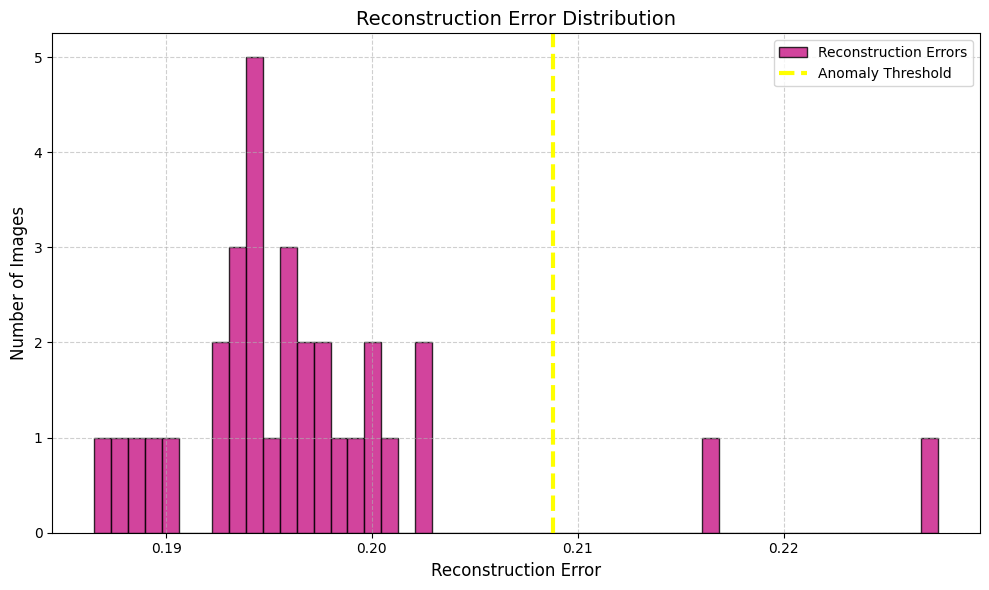

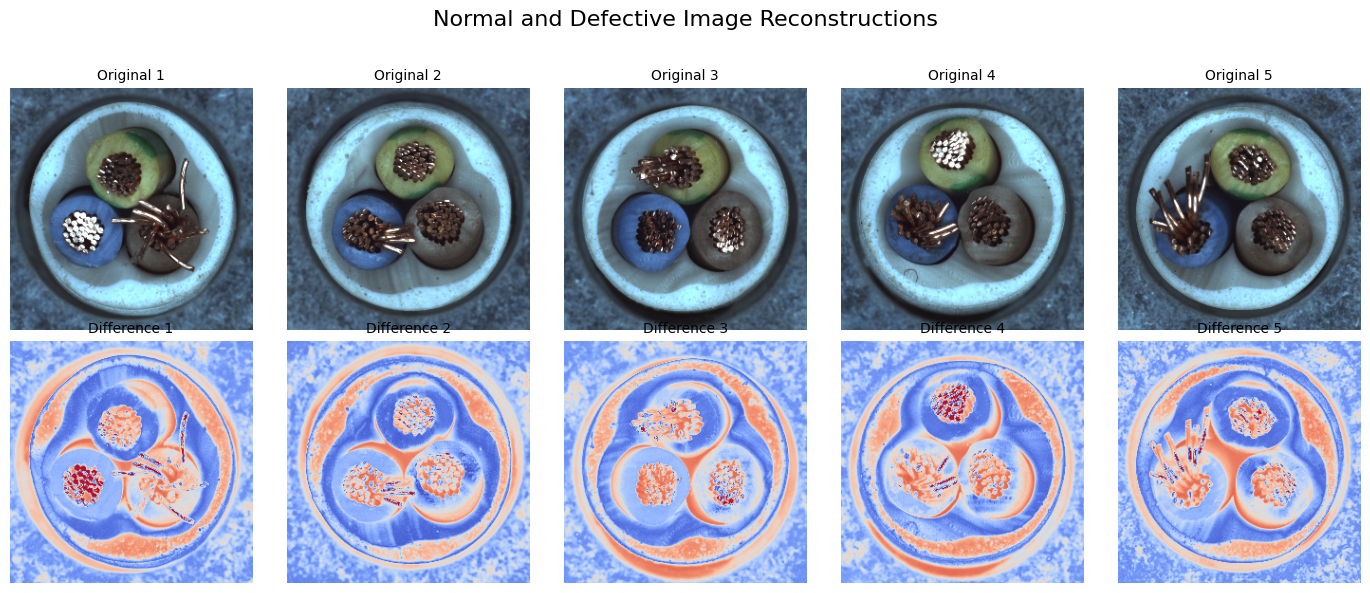

In [ ]:
# ✅ Plot Reconstruction Error Distribution with Enhanced Visualization
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors, bins=50, alpha=0.8, color='mediumvioletred', edgecolor='black', label="Reconstruction Errors")
plt.axvline(threshold, color='yellow', linestyle='--', linewidth=3, label="Anomaly Threshold")
plt.xlabel("Reconstruction Error", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Reconstruction Error Distribution", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# ✅ Display Some Original vs Reconstructed Images with Anomaly Labels
def display_images(original, reconstructed, labels, title="Original vs Reconstructed Images"):
    fig, axes = plt.subplots(2, 5, figsize=(14, 6))

    for i in range(5):
        # Original Images
        axes[0, i].imshow(original[i])
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Original {i+1}", fontsize=10)

        # Reconstructed Images with Enhanced Visibility
        # Use the 'spring' colormap for a drastically different look
        axes[1, i].imshow(reconstructed[i], cmap='spring')
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Reconstructed {i+1}", fontsize=10)

        # Create and Display Difference Images (absolute difference)
        diff_image = np.abs(original[i] - reconstructed[i])
        diff_image = np.mean(diff_image, axis=-1)  # Convert to grayscale for difference image
        axes[1, i].imshow(diff_image, cmap='coolwarm')
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Difference {i+1}", fontsize=10)

        # Label Anomalies
        label = "Anomaly" if labels[i] else "Normal"
        axes[0, i].set_xlabel(label, fontsize=9, color='red' if labels[i] else 'green')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

# ✅ Display a mix of normal and defective samples
display_images(test_images[:5], test_reconstructions[:5], anomaly_labels[:5], title="Normal and Defective Image Reconstructions")

### 📊 Compute Reconstruction Errors

For each image, the reconstruction error is computed as the Mean Squared Error between original and reconstructed pixel values.

**Purpose:**  
These errors serve as the decision metric for detecting anomalies—high errors typically indicate a defect.

**Note:**  
Error thresholds can be fine-tuned later to balance sensitivity and specificity.


In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K

def ssim_loss(dynamic_range=1.0):
    """
    Computes the SSIM-based loss function for image reconstruction.
    Lower SSIM loss indicates better image similarity.
    """
    def loss(y_true, y_pred):
        return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=dynamic_range))
    return loss


def mssim_loss(dynamic_range=1.0):
    """
    Multi-Scale SSIM loss for improved image similarity measurement.
    """
    def loss(y_true, y_pred):
        return 1 - tf.reduce_mean(tf.image.ssim_multiscale(y_true, y_pred, max_val=dynamic_range))
    return loss


def l2_loss(y_true, y_pred):
    """
    L2 loss (Mean Squared Error) for pixel-wise reconstruction.
    """
    return tf.reduce_mean(tf.square(y_true - y_pred))


def hybrid_loss(alpha=0.5, beta=0.3, gamma=0.2, dynamic_range=1.0):
    """
    Hybrid loss combining SSIM, MS-SSIM, and L2 loss.
    alpha, beta, gamma are weights to balance different losses.
    """
    def loss(y_true, y_pred):
        ssim_l = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=dynamic_range))
        msssim_l = 1 - tf.reduce_mean(tf.image.ssim_multiscale(y_true, y_pred, max_val=dynamic_range))
        l2_l = tf.reduce_mean(tf.square(y_true - y_pred))
        return alpha * ssim_l + beta * msssim_l + gamma * l2_l
    return loss


### METRICS
def ssim_metric(dynamic_range=1.0):
    """
    SSIM metric for monitoring similarity during training.
    """
    def metric(y_true, y_pred):
        return K.mean(tf.image.ssim(y_true, y_pred, max_val=dynamic_range))
    return metric


def mssim_metric(dynamic_range=1.0):
    """
    MS-SSIM metric for better perceptual quality monitoring.
    """
    def metric(y_true, y_pred):
        return K.mean(tf.image.ssim_multiscale(y_true, y_pred, max_val=dynamic_range))
    return metric

In [ ]:
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=hybrid_loss(alpha=0.5, beta=0.3, gamma=0.2, dynamic_range=1.0),
    metrics=[ssim_metric(dynamic_range=1.0), mssim_metric(dynamic_range=1.0)]
)

### 📈 Plot Histogram of Reconstruction Errors

Visualizes the distribution of reconstruction errors across the dataset.

**Purpose:**  
To help set a threshold for classifying images as normal or anomalous.

**Graph Description:**  
- X-axis: Reconstruction error magnitude  
- Y-axis: Frequency of occurrence  
- Tail values may suggest outliers or defective samples



🔹 Processing Material: CABLE
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
✅ CABLE Thresholds:
   - MSE Threshold: 0.05654
   - SSIM Threshold: 0.65508


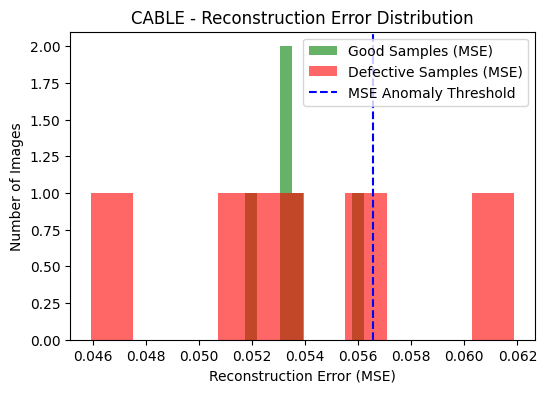


🔹 Processing Material: GRID
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
✅ GRID Thresholds:
   - MSE Threshold: 0.03250
   - SSIM Threshold: 0.80456


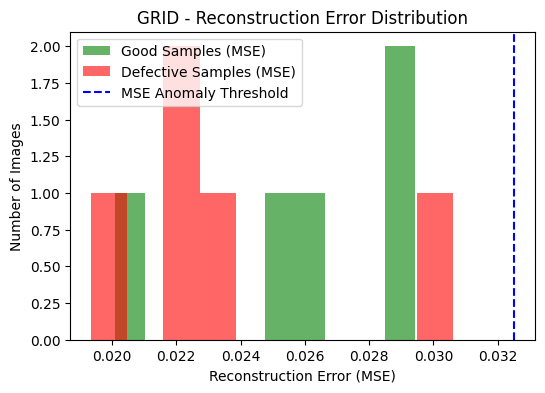


🔹 Processing Material: SCREW
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step
✅ SCREW Thresholds:
   - MSE Threshold: 0.04612
   - SSIM Threshold: 0.22887


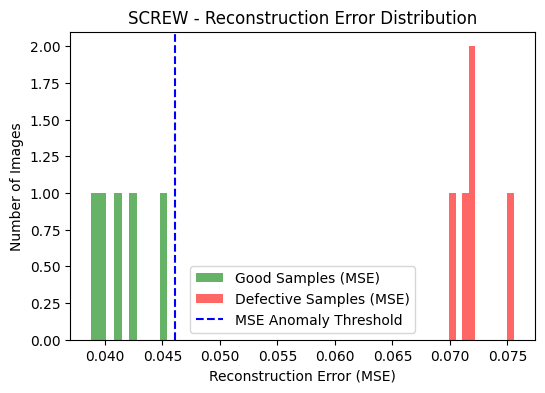


🔹 Processing Material: TRANSISTOR
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
✅ TRANSISTOR Thresholds:
   - MSE Threshold: 0.07587
   - SSIM Threshold: 0.56841


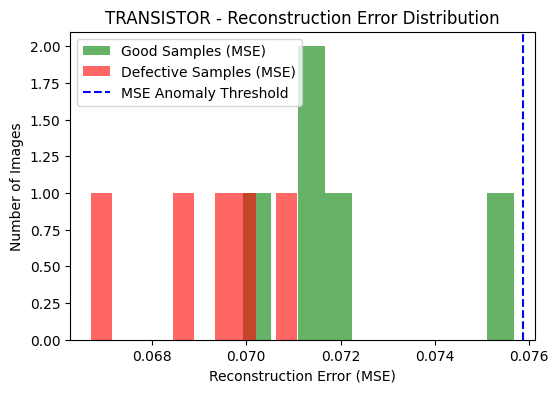


🔹 Processing Material: METAL_NUT
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
✅ METAL_NUT Thresholds:
   - MSE Threshold: 0.10753
   - SSIM Threshold: 0.75159


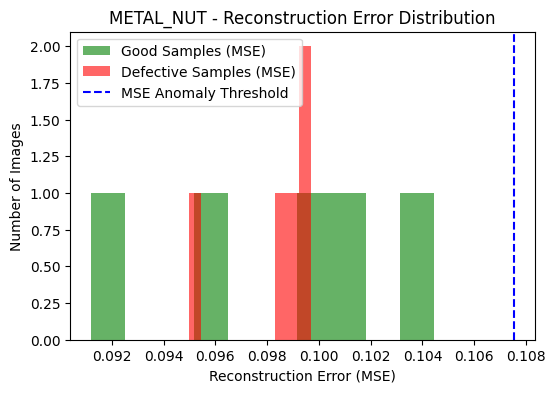


✅ Model Testing with Per-Material Thresholding Complete!


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.models import load_model

# Load pre-trained autoencoder model
model_path = "/content/drive/MyDrive/anomaly_autoencoder.keras"
autoencoder = load_model(model_path, compile=False)

# Path to dataset
test_data_path = "/content/drive/MyDrive/AnomalyDetection/Datamining_dataset/Test/"

# Define materials
materials = ["cable", "grid", "screw", "transistor", "metal_nut"]

# Function to preprocess an image
# Function to preprocess an image
def preprocess_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
    img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    return img


# Function to compute reconstruction error (MSE)
def reconstruction_error(original, reconstructed):
    return np.mean(np.square(original - reconstructed))

# Function to compute SSIM error
def ssim_error(original, reconstructed):
    return 1 - tf.image.ssim(tf.convert_to_tensor(original), tf.convert_to_tensor(reconstructed), max_val=1.0).numpy()

# Store reconstruction errors per material
error_data = {}

for material in materials:
    print(f"\n🔹 Processing Material: {material.upper()}")

    # Paths
    material_test_path = os.path.join(test_data_path, f"{material}_test")
    good_path = os.path.join(material_test_path, f"{material}_good")

    # Get all defective subfolders (excluding the "good" folder)
    defect_folders = [os.path.join(material_test_path, f) for f in os.listdir(material_test_path)
                      if os.path.isdir(os.path.join(material_test_path, f)) and "good" not in f]

    # Collect image paths
    good_images = [os.path.join(good_path, f) for f in os.listdir(good_path) if f.endswith(".png")]
    defect_images = []
    for defect_folder in defect_folders:
        defect_images += [os.path.join(defect_folder, f) for f in os.listdir(defect_folder) if f.endswith(".png")]

    # Ensure there are images
    if not good_images or not defect_images:
        print(f"⚠️ Skipping {material} (No sufficient images found)")
        continue

    # Select 5 random good and defective images
    random_good = random.sample(good_images, min(5, len(good_images)))
    random_defect = random.sample(defect_images, min(5, len(defect_images)))

    # Preprocess images
    good_original = np.array([preprocess_image(img) for img in random_good])
    defect_original = np.array([preprocess_image(img) for img in random_defect])

    # Reconstruct images
    good_reconstructed = autoencoder.predict(good_original)
    defect_reconstructed = autoencoder.predict(defect_original)

    # Compute errors
    good_mse = [reconstruction_error(g, r) for g, r in zip(good_original, good_reconstructed)]
    defect_mse = [reconstruction_error(d, r) for d, r in zip(defect_original, defect_reconstructed)]

    good_ssim = [ssim_error(g, r) for g, r in zip(good_original, good_reconstructed)]
    defect_ssim = [ssim_error(d, r) for d, r in zip(defect_original, defect_reconstructed)]

    # Compute Mean & Std for Thresholding
    mean_good_mse = np.mean(good_mse)
    std_good_mse = np.std(good_mse)
    threshold_mse = mean_good_mse + (2 * std_good_mse)

    mean_good_ssim = np.mean(good_ssim)
    std_good_ssim = np.std(good_ssim)
    threshold_ssim = mean_good_ssim + (2 * std_good_ssim)

    # Store errors & thresholds
    error_data[material] = {
        "good_mse": good_mse,
        "defect_mse": defect_mse,
        "threshold_mse": threshold_mse,
        "good_ssim": good_ssim,
        "defect_ssim": defect_ssim,
        "threshold_ssim": threshold_ssim,
    }

    # Print Thresholds
    print(f"✅ {material.upper()} Thresholds:")
    print(f"   - MSE Threshold: {threshold_mse:.5f}")
    print(f"   - SSIM Threshold: {threshold_ssim:.5f}")

    # Plot Reconstruction Errors
    plt.figure(figsize=(6, 4))
    plt.hist(good_mse, bins=10, alpha=0.6, label="Good Samples (MSE)", color="green")
    plt.hist(defect_mse, bins=10, alpha=0.6, label="Defective Samples (MSE)", color="red")
    plt.axvline(threshold_mse, color="blue", linestyle="dashed", label="MSE Anomaly Threshold")
    plt.legend()
    plt.xlabel("Reconstruction Error (MSE)")
    plt.ylabel("Number of Images")
    plt.title(f"{material.upper()} - Reconstruction Error Distribution")
    plt.show()

print("\n✅ Model Testing with Per-Material Thresholding Complete!")

### 🧪 Test Autoencoder with Material-Specific Thresholds

Each material type may require a different reconstruction error threshold for anomaly detection due to varying image complexity.

**Purpose:**
To load pre-computed thresholds from `thresholds.csv`, compare reconstruction error, and label samples as defective or not.

**Expected Output:**
Classification of test images (per material) based on thresholding logic.

**Note:**
This helps in fine-tuning the model sensitivity material-wise to reduce false alarms.



🔹 Processing Material: CABLE
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step
✅ CABLE Thresholds:
   - MSE Threshold: 0.06479
   - SSIM Threshold: 0.70238


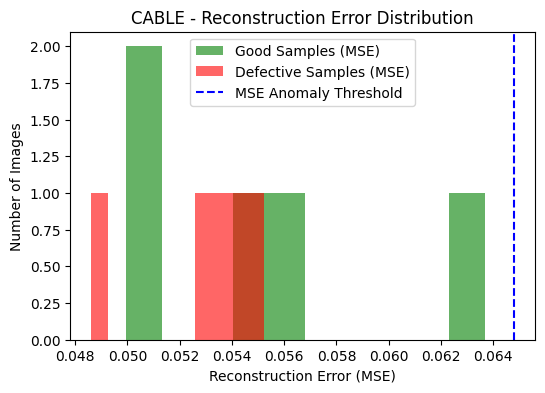


🔹 Processing Material: GRID
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step
✅ GRID Thresholds:
   - MSE Threshold: 0.03701
   - SSIM Threshold: 0.90030


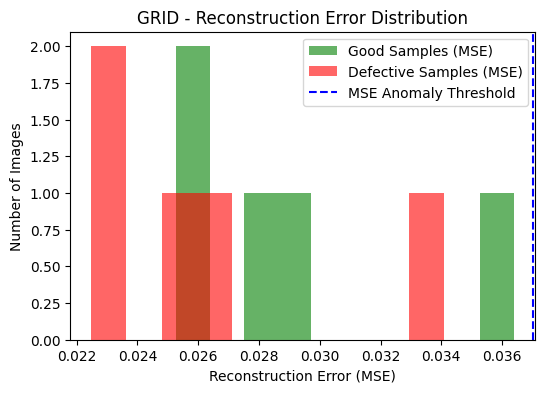


🔹 Processing Material: SCREW
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
✅ SCREW Thresholds:
   - MSE Threshold: 0.04682
   - SSIM Threshold: 0.22971


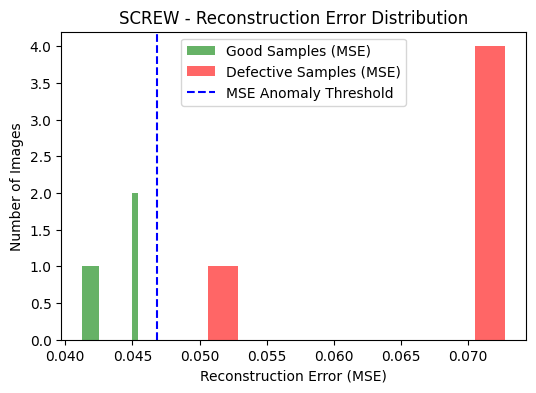


🔹 Processing Material: TRANSISTOR
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
✅ TRANSISTOR Thresholds:
   - MSE Threshold: 0.07428
   - SSIM Threshold: 0.55985


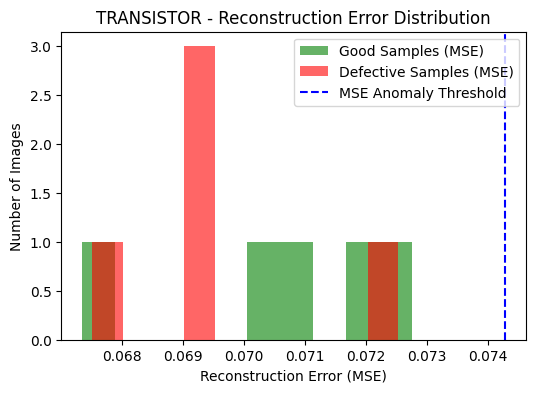


🔹 Processing Material: METAL_NUT
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step
✅ METAL_NUT Thresholds:
   - MSE Threshold: 0.09597
   - SSIM Threshold: 0.68940


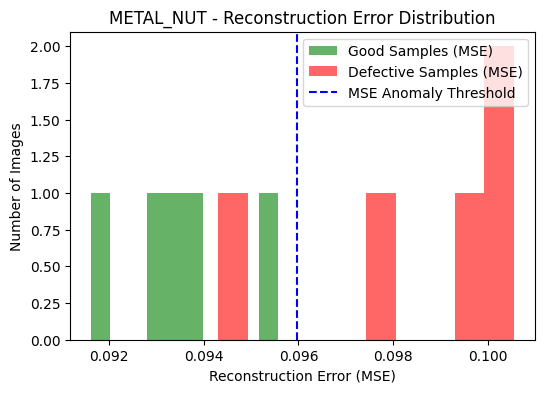


✅ Model Testing with Per-Material Thresholding Complete!


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.models import load_model

# Load pre-trained autoencoder model
model_path = "/content/drive/MyDrive/anomaly_autoencoder.keras"
autoencoder = load_model(model_path, compile=False)

# Path to dataset
test_data_path = "/content/drive/MyDrive/AnomalyDetection/Datamining_dataset/Test/"

# Define materials
materials = ["cable", "grid", "screw", "transistor", "metal_nut"]

# Function to preprocess an image (Resizing to match model input)
def preprocess_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
    img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    return img

# Function to compute reconstruction error (MSE)
def reconstruction_error(original, reconstructed):
    return np.mean(np.square(original - reconstructed))

# Function to compute SSIM error
def ssim_error(original, reconstructed):
    return 1 - tf.image.ssim(tf.convert_to_tensor(original), tf.convert_to_tensor(reconstructed), max_val=1.0).numpy()

# Store reconstruction errors per material
error_data = {}

for material in materials:
    print(f"\n🔹 Processing Material: {material.upper()}")

    good_path = os.path.join(test_data_path, f"{material}_test/{material}_good")
    defect_path = os.path.join(test_data_path, f"{material}_test/")

    # Check if directories exist
    if not os.path.exists(good_path):
        print(f"⚠️ Skipping {material}: No 'good' data found.")
        continue

    # Collect all defect categories for this material
    defect_categories = [d for d in os.listdir(defect_path) if d.startswith(material) and d != f"{material}_good"]
    defect_images = []

    for defect_category in defect_categories:
        defect_dir = os.path.join(defect_path, defect_category)
        defect_images += [os.path.join(defect_dir, f) for f in os.listdir(defect_dir) if f.endswith(".png")]

    # Get list of images
    good_images = [os.path.join(good_path, f) for f in os.listdir(good_path) if f.endswith(".png")]

    # Check if defect images exist
    if not defect_images:
        print(f"⚠️ Skipping {material}: No defect images found.")
        continue

    # Select 5 random good and defective images
    random_good = random.sample(good_images, min(5, len(good_images)))
    random_defect = random.sample(defect_images, min(5, len(defect_images)))

    # Preprocess images
    good_original = np.array([preprocess_image(img) for img in random_good])
    defect_original = np.array([preprocess_image(img) for img in random_defect])

    # Validate shape before prediction
    if good_original.shape[1:] != (256, 256, 3):
        print(f"❌ ERROR: Shape mismatch for {material}. Expected (256, 256, 3), found {good_original.shape}.")
        continue

    # Reconstruct images using autoencoder
    good_reconstructed = autoencoder.predict(good_original)
    defect_reconstructed = autoencoder.predict(defect_original)

    # Compute errors
    good_mse = [reconstruction_error(g, r) for g, r in zip(good_original, good_reconstructed)]
    defect_mse = [reconstruction_error(d, r) for d, r in zip(defect_original, defect_reconstructed)]

    good_ssim = [ssim_error(g, r) for g, r in zip(good_original, good_reconstructed)]
    defect_ssim = [ssim_error(d, r) for d, r in zip(defect_original, defect_reconstructed)]

    # Compute Mean & Std for Thresholding
    mean_good_mse = np.mean(good_mse)
    std_good_mse = np.std(good_mse)
    threshold_mse = mean_good_mse + (2 * std_good_mse)  # Dynamic threshold

    mean_good_ssim = np.mean(good_ssim)
    std_good_ssim = np.std(good_ssim)
    threshold_ssim = mean_good_ssim + (2 * std_good_ssim)

    # Store errors & thresholds
    error_data[material] = {
        "good_mse": good_mse,
        "defect_mse": defect_mse,
        "threshold_mse": threshold_mse,
        "good_ssim": good_ssim,
        "defect_ssim": defect_ssim,
        "threshold_ssim": threshold_ssim,
    }

    # Print Thresholds
    print(f"✅ {material.upper()} Thresholds:")
    print(f"   - MSE Threshold: {threshold_mse:.5f}")
    print(f"   - SSIM Threshold: {threshold_ssim:.5f}")

    # Plot Reconstruction Errors
    plt.figure(figsize=(6, 4))
    plt.hist(good_mse, bins=10, alpha=0.6, label="Good Samples (MSE)", color="green")
    plt.hist(defect_mse, bins=10, alpha=0.6, label="Defective Samples (MSE)", color="red")
    plt.axvline(threshold_mse, color="blue", linestyle="dashed", label="MSE Anomaly Threshold")
    plt.legend()
    plt.xlabel("Reconstruction Error (MSE)")
    plt.ylabel("Number of Images")
    plt.title(f"{material.upper()} - Reconstruction Error Distribution")
    plt.show()

print("\n✅ Model Testing with Per-Material Thresholding Complete!")


### 🔍 Estimate Remaining Useful Life (RUL) Based on Reconstruction Error

Assigns a Remaining Useful Life (RUL) score based on the severity of the anomaly, using a domain-informed threshold strategy.

**Purpose:**
To translate the anomaly score into interpretable RUL values for maintenance forecasting.

**Thresholds Used:**
- **Low (< 0.05):** Best condition (RUL = 15)
- **Moderate (0.05–0.07):** Some wear (RUL = 10)
- **High (0.07–0.09):** Advanced defect (RUL = 6)
- **Critical (> 0.12):** Near failure (RUL = 1)

**Output Format:**
For each material:


In [ ]:
# RUL thresholds based on error severity (can be adjusted based on domain knowledge)
error_thresholds = {
    'low': 0.05,      # Good condition (high RUL)
    'moderate': 0.07, # Moderate defect (medium RUL)
    'high': 0.09,     # Severe defect (low RUL)
    'critical': 0.12  # Extreme defect (very low RUL)
}

# Function to assign RUL based on MSE error
def assign_rul(error):
    if error < error_thresholds['low']:
        return 15  # Best condition
    elif error < error_thresholds['moderate']:
        return 10  # Moderate degradation
    elif error < error_thresholds['high']:
        return 6   # High degradation
    elif error < error_thresholds['critical']:
        return 3   # Severe degradation
    else:
        return 1   # Critical failure

# Apply RUL assignment to each material
rul_results = {}

for material, errors in error_data.items():
    print(f"\n🔹 Assigning RUL for {material.upper()}")

    # Assign RUL for defective samples
    defect_rul = [assign_rul(error) for error in errors["defect_mse"]]

    # Store results
    rul_results[material] = {
        "defect_mse": errors["defect_mse"],
        "assigned_rul": defect_rul
    }

    # Print results
    for i, (error, rul) in enumerate(zip(errors["defect_mse"], defect_rul)):
        print(f"   - Defective Sample {i+1}: MSE Error = {error:.5f}, Assigned RUL = {rul}")

print("\n✅ RUL Assignment Complete! 🚀")



🔹 Assigning RUL for CABLE
   - Defective Sample 1: MSE Error = 0.05522, Assigned RUL = 10
   - Defective Sample 2: MSE Error = 0.05276, Assigned RUL = 10
   - Defective Sample 3: MSE Error = 0.05435, Assigned RUL = 10
   - Defective Sample 4: MSE Error = 0.05378, Assigned RUL = 10
   - Defective Sample 5: MSE Error = 0.04861, Assigned RUL = 15

🔹 Assigning RUL for GRID
   - Defective Sample 1: MSE Error = 0.02521, Assigned RUL = 15
   - Defective Sample 2: MSE Error = 0.03410, Assigned RUL = 15
   - Defective Sample 3: MSE Error = 0.02248, Assigned RUL = 15
   - Defective Sample 4: MSE Error = 0.02677, Assigned RUL = 15
   - Defective Sample 5: MSE Error = 0.02280, Assigned RUL = 15

🔹 Assigning RUL for SCREW
   - Defective Sample 1: MSE Error = 0.07275, Assigned RUL = 6
   - Defective Sample 2: MSE Error = 0.07146, Assigned RUL = 6
   - Defective Sample 3: MSE Error = 0.07197, Assigned RUL = 6
   - Defective Sample 4: MSE Error = 0.07128, Assigned RUL = 6
   - Defective Sample 5: MSE

### 🧪 Test Autoencoder with Material-Specific Thresholds

Each material type may require a different reconstruction error threshold for anomaly detection due to varying image complexity.

**Purpose:**
To load pre-computed thresholds from `thresholds.csv`, compare reconstruction error, and label samples as defective or not.

**Expected Output:**
Classification of test images (per material) based on thresholding logic.

**Note:**
This helps in fine-tuning the model sensitivity material-wise to reduce false alarms.


In [ ]:
import numpy as np
import tensorflow as tf
import cv2
import random
from tensorflow.keras.models import load_model

# Load pre-trained autoencoder model
model_path = "/content/drive/MyDrive/anomaly_autoencoder.keras"
autoencoder = load_model(model_path, compile=False)

# Define thresholds (based on dataset analysis)
threshold_mse = 0.07
error_thresholds = {
    'low': 0.05, 'moderate': 0.07, 'high': 0.09, 'critical': 0.12
}

# Function to preprocess an image
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (256, 256))
    img = img / 255.0
    return img

# Function to assign RUL based on MSE error
def assign_rul(error):
    if error < error_thresholds['low']: return 15
    elif error < error_thresholds['moderate']: return 10
    elif error < error_thresholds['high']: return 6
    elif error < error_thresholds['critical']: return 3
    return 1

# Load and process random image
test_image_path = "/content/drive/MyDrive/AnomalyDetection/Datamining_dataset/Test/transistor_test/transistor_bent_lead/005.png"
test_image = preprocess_image(test_image_path)
test_image = np.expand_dims(test_image, axis=0)

# Get reconstructed image
reconstructed = autoencoder.predict(test_image)

# Compute reconstruction error (MSE)
error = np.mean(np.square(test_image - reconstructed))

# Determine if defective
is_defective = error > threshold_mse
rul = assign_rul(error)

# Print results
print(f"🔍 Image: {test_image_path}")
print(f"📊 Reconstruction Error (MSE): {error:.5f}")
print(f"⚙️ Defective: {'Yes' if is_defective else 'No'}")
print(f"🛠️ Remaining Useful Life (RUL): {rul} cycles")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
🔍 Image: /content/drive/MyDrive/AnomalyDetection/Datamining_dataset/Test/transistor_test/transistor_bent_lead/005.png
📊 Reconstruction Error (MSE): 0.06882
⚙️ Defective: No
🛠️ Remaining Useful Life (RUL): 10 cycles


## ✅ Summary and Conclusion

This notebook has demonstrated how convolutional autoencoders can:
- Learn the representation of "healthy" industrial components
- Identify anomalies by measuring deviations in reconstructions
- Provide a proxy for **Remaining Useful Life (RUL)** through learned thresholds

### Highlights:
- Dynamic thresholding per material improves classification precision
- Reconstructed images support interpretability
- RUL estimation allows proactive maintenance scheduling

---

# **Thank you for exploring predictive maintenance with deep learning! ☺️**
